In [ ]:
# NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.
# datasets 최신 버전으로 변경
!pip install datasets==2.20.0

In [2]:
import pandas as pd
import numpy as np
import hashlib
from tqdm import tqdm
from datasets import load_dataset
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## 영화 리뷰 테이블 구성

사용자가 각 영화를 시청하고 리뷰를 남긴 테이블을 Pandas DataFrame으로 구성.

| 사용자 / 영화 | 영화 1 | 영화 2 | 영화 3 | 영화 4 | 영화 5 |
|--------------|-------|-------|-------|-------|-------|
| 사용자 1      | 4.0   | -     | 5.0   | 3.0   | 4.0   |
| 사용자 2      | 5.0   | 4.0   | -     | 3.0   | 3.0   |
| 사용자 3      | -     | 3.0   | 4.0   | 5.0   | 4.0   |
| 사용자 4      | 2.0   | 3.0   | 5.0   | -     | 2.0   |
| 사용자 5      | 4.0   | 4.0   | 4.0   | 4.0   | -     |


In [3]:
data = {
    "영화 1": [4, 5, None, 2, 4],
    "영화 2": [None, 4, 3, 3, 4],
    "영화 3": [5, None, 4, 5, 4],
    "영화 4": [3, 3, 5, None, 4],
    "영화 5": [4, 3, 4, 2, None]
}
df = pd.DataFrame(data, index=["사용자 1", "사용자 2", "사용자 3", "사용자 4", "사용자 5"])

In [4]:
df

,영화 1,영화 2,영화 3,영화 4,영화 5
사용자 1,4.0,NaN,5.0,3.0,4.0
사용자 2,5.0,4.0,NaN,3.0,3.0
사용자 3,NaN,3.0,4.0,5.0,4.0
사용자 4,2.0,3.0,5.0,NaN,2.0
사용자 5,4.0,4.0,4.0,4.0,NaN


## 사용자 유사도 테이블 구성

Scikit Learn의 코사인 유사도(Cosine Similarity) 함수를 통해, 사용자 유사도 매트릭스 구성.

In [5]:
user_df = df.copy()
user_df = user_df.fillna(0)
user_similarity = cosine_similarity(user_df, user_df)
user_similarity_df = pd.DataFrame(user_similarity, index=user_df.index, columns=user_df.index)
user_similarity_df

# 사용자1은 사용자3, 사용자4와 유사도 높다.

,사용자 1,사용자 2,사용자 3,사용자 4,사용자 5
사용자 1,1.000000,0.657031,0.772727,0.778731,0.738549
사용자 2,0.657031,1.000000,0.624981,0.562480,0.781133
사용자 3,0.772727,0.624981,1.000000,0.702757,0.738549
사용자 4,0.778731,0.562480,0.702757,1.000000,0.771517
사용자 5,0.738549,0.781133,0.738549,0.771517,1.000000


## 아이템 유사도 테이블 구성

Scikit Learn의 코사인 유사도(Cosine Similarity) 함수를 통해, 아이템 유사도 매트릭스 구성.

In [6]:
item_df = np.transpose(df.copy()) # 전치
item_df = item_df.fillna(0)
item_similarity = cosine_similarity(item_df, item_df)
item_similarity_df = pd.DataFrame(item_similarity, index=item_df.index, columns=item_df.index)
item_similarity_df

,영화 1,영화 2,영화 3,영화 4,영화 5
영화 1,1.000000,0.760500,0.650408,0.716766,0.668031
영화 2,0.760500,1.000000,0.671547,0.791694,0.632456
영화 3,0.650408,0.671547,1.000000,0.733225,0.757259
영화 4,0.716766,0.791694,0.733225,1.000000,0.795704
영화 5,0.668031,0.632456,0.757259,0.795704,1.000000


## 사용자 기반 Collaborative Filtering

각 사용자의 유사도 정보를 반영하여 결측치의 평점 계산.

In [7]:
full_df = df.copy()
for user_id in full_df.index:
    for movie_id in full_df.columns:
        # 결측치가 아닌 데이터는 PASS
        if not np.isnan(full_df[movie_id][user_id]): continue

        # 해당 사용자의 다른 사용자들과의 유사도
        similarities = user_similarity_df[user_id].copy()

        # 해당 영화에 대한 모든 사용자의 평점
        movie_ratings = full_df[movie_id].copy()

        # 평점이 비어있는 사용자 목록
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index

        # 평점 있는 사용자만 남김
        movie_ratings = movie_ratings.dropna()

        # 결측치인 사용자는 유사도에서도 제거
        similarities = similarities.drop(none_rating_idx)

        # dot = 해당 사용자와 다른 사용자의 유사도 * 다른 사용자의 영화 A에 대한 평점
        mean_rating = np.dot(similarities, movie_ratings) / similarities.sum()

        # 소수점은 반올림해서 정수 평점으로 예측값을 채움
        full_df.loc[user_id, movie_id] = round(mean_rating)

full_df

,영화 1,영화 2,영화 3,영화 4,영화 5
사용자 1,4.0,3.0,5.0,3.0,4.0
사용자 2,5.0,4.0,4.0,3.0,3.0
사용자 3,4.0,3.0,4.0,5.0,4.0
사용자 4,2.0,3.0,5.0,4.0,2.0
사용자 5,4.0,4.0,4.0,4.0,3.0


In [8]:
watched_movies = ["영화 4", "영화 3"] # 최신순 - 영화 3번을 보고, 영화 4를 봤다고 가정
# 영화 4를 마지막에 봤고, 지금까지 본 영화 목록을 제외하고 나서, similarity 기준으로 정렬, 그 중에서 유사도 높은 순으로 3개를 뽑음
# 가장 마지막에 봤던 영화 4를 바탕으로 그 다음에 어떤 영화를 봐야될지를 추천
item_similarity_df[watched_movies[0]][~item_similarity_df.index.isin(watched_movies)].sort_values(ascending=False)[:3]

,영화 4
영화 5,0.795704
영화 2,0.791694
영화 1,0.716766


In [9]:
!rm -rf ~/.cache/huggingface/datasets
!rm -rf ~/.cache/huggingface/hub

In [ ]:
# 다른 데이터셋 이용
data = load_dataset("ashraq/movielens_ratings")["train"].shuffle(seed=10)

# 대용량 데이터를 한 번에 DataFrame으로 만들면 터질 수 있음 -> chunk로 쪼개서 불러옴
n_chunks = 100
chunk_size = len(data) // n_chunks
if len(data) % n_chunks != 0: chunk_size += 1

movielens_df = pd.DataFrame()

for start in tqdm(range(0, len(data), chunk_size)):
  end = start + chunk_size
  chunk_df = pd.DataFrame(data[start:end])
  movielens_df = pd.concat([movielens_df, chunk_df], ignore_index=True)

movielens_df = movielens_df[["user_id", "movie_id", "rating"]]

In [11]:
movielens_df

,user_id,movie_id,rating
0,39614,3321,2.5
1,499,1399,3.0
2,43195,218,4.5
3,28559,510,4.0
4,40341,10585,5.0
...,...,...,...
891377,42168,2324,2.0
891378,31890,137,4.0
891379,3099,4462,4.5
891380,12146,7089,3.5


In [12]:
movielens_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891382 entries, 0 to 891381
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   891382 non-null  int64  
 1   movie_id  891382 non-null  int64  
 2   rating    891382 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 20.4 MB


In [13]:
user_item_matrix = movielens_df.pivot_table(index="user_id", columns="movie_id", values="rating")
user_item_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,15595,15596,15597,15598,15599,15600,15601,15602,15603,15604
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# colab RAM 부족 에러 -> 6000명만 가져옴
user_item_matrix_6000 = user_item_matrix.sample(n=6000, random_state=42)
user_item_matrix_6000

movie_id,1,2,3,4,5,6,7,8,9,10,...,15595,15596,15597,15598,15599,15600,15601,15602,15603,15604
user_id,,,,,,,,,,,,,,,,,,,,,
2387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1311,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# 사용자-아이템 평점 행렬에서 결측치를 0으로 채운 후 희소행렬로 변환하여 사용자 간 코사인 유사도 계산
# 대부분 공백(NaN): 희소(sparse)한 구조 -> 왜 희소행렬 사용?
# 메모리 절약, 계산 속도 향상 -> 평점이 존재하는 셀만 저장, 0을 무시하고 빠르게 계산
# 결측치 데이터를 압축하는 효과
user_similarity = cosine_similarity(csr_matrix(user_item_matrix_6000.fillna(0)))
user_similarity = pd.DataFrame(user_similarity, index=user_item_matrix_6000.index, columns=user_item_matrix_6000.index)

def predict_rating(user_id: int, movie_id: int):
  # 모든 사용자들의 해당 영화에 대한 평점
  movie_ratings = user_item_matrix_6000[movie_id]

  # 예측 대상 사용자(user_id)와 다른 사용자 간의 유사도
  user_similarities = user_similarity[user_id]

  # 해당 영화에 대해 실제 평점을 남긴 사용자만 필터링
  valid_indices = movie_ratings.notna()
  movie_ratings = movie_ratings[valid_indices] # 실제 평점이 있는 사용자들의 평점만 남김
  user_similarities = user_similarities[valid_indices] # 그 사용자들과의 유사도만 남김

  # 유사도의 총합이 0보다 크면 (즉, 유사한 사용자가 존재하면)
  if user_similarities.sum() > 0:
  # 유사도 가중 평균 방식으로 예측 평점 계산
    return np.dot(user_similarities, movie_ratings) / user_similarities.sum()

  # 유사한 사용자도 없고 예측할 수 없다면 -> 해당 영화의 전체 평균 평점을 반환
  return movielens_df[movielens_df["movie_id"] == movie_id]["user_rating"].mean()

user_similarity

user_id,2387,853,38028,1311,24200,33649,5937,9769,9932,35615,...,35200,9406,43389,8651,42700,1352,15142,7320,34074,282
user_id,,,,,,,,,,,,,,,,,,,,,
2387,1.000000,0.077884,0.163220,0.071128,0.040035,0.081460,0.157694,0.154855,0.165457,0.000000,...,0.125716,0.040609,0.159407,0.124050,0.000000,0.000000,0.000000,0.000000,0.058862,0.379434
853,0.077884,1.000000,0.049191,0.026218,0.000000,0.000000,0.000000,0.058531,0.000000,0.000000,...,0.000000,0.040017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127264
38028,0.163220,0.049191,1.000000,0.170256,0.029500,0.066149,0.000000,0.297406,0.000000,0.000000,...,0.233239,0.101191,0.000000,0.000000,0.000000,0.000000,0.197157,0.132662,0.126134,0.211301
1311,0.071128,0.026218,0.170256,1.000000,0.173191,0.157395,0.089520,0.248266,0.039608,0.058898,...,0.084013,0.210517,0.096913,0.116896,0.091306,0.116013,0.134863,0.078387,0.099892,0.063483
24200,0.040035,0.000000,0.029500,0.173191,1.000000,0.284329,0.103203,0.262209,0.108283,0.247532,...,0.000000,0.068450,0.212511,0.165376,0.121630,0.130195,0.013620,0.000000,0.171744,0.056072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,0.000000,0.000000,0.000000,0.116013,0.130195,0.130713,0.141702,0.175122,0.000000,0.338138,...,0.023535,0.026122,0.341050,0.548502,0.342742,1.000000,0.000000,0.000000,0.000000,0.000000
15142,0.000000,0.000000,0.197157,0.134863,0.013620,0.138561,0.000000,0.062715,0.000000,0.000000,...,0.000000,0.051787,0.000000,0.000000,0.000000,0.000000,1.000000,0.230857,0.000000,0.000000
7320,0.000000,0.000000,0.132662,0.078387,0.000000,0.080324,0.000000,0.065441,0.000000,0.000000,...,0.142364,0.055524,0.000000,0.000000,0.000000,0.000000,0.230857,1.000000,0.193168,0.000000


In [18]:
# user_item_matrix_6000에 포함된 사용자만 필터링
user_ids_6000 = user_item_matrix_6000.index
movielens_df_6000 = movielens_df[movielens_df["user_id"].isin(user_ids_6000)]

100%|██████████| 2276/2276 [00:02<00:00, 1066.44it/s]


Accuracy: 0.5689806678383128


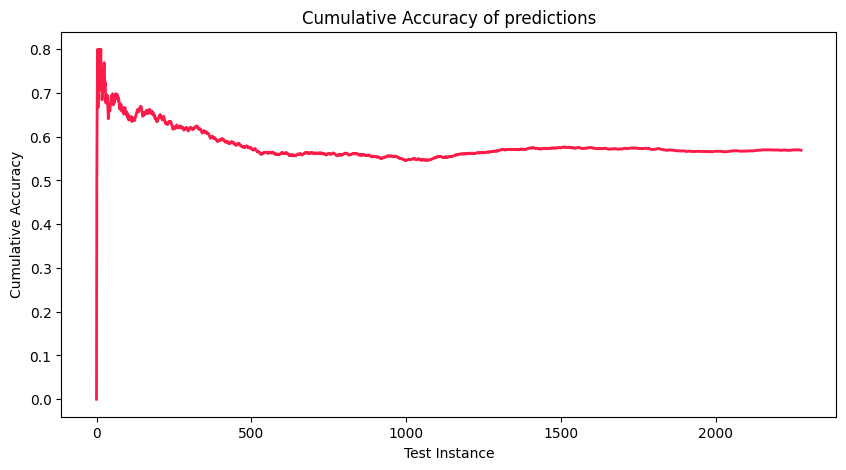

In [22]:
train_data, test_data = train_test_split(movielens_df_6000, test_size=0.02, random_state=10)

predictions: list[float] = []
true_ratings: list[float] = []

for idx, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
    prediction = predict_rating(row["user_id"], row["movie_id"])
    predictions.append(prediction)
    true_ratings.append(round(row["rating"])) # 정답 평점

rounded_predictions = [round(pred) for pred in predictions] # 예측 평점
accuracy = accuracy_score(true_ratings, rounded_predictions)
print(f"Accuracy: {accuracy}")

cumulative_accuracy = np.cumsum(np.array(rounded_predictions) == np.array(true_ratings)) / (np.arange(len(test_data)) + 1)

plt.figure(figsize=(10, 5))
plt.plot([i for i in range(len(test_data))], cumulative_accuracy, linewidth=2, color="#fc1c49")
plt.title("Cumulative Accuracy of predictions")
plt.xlabel("Test Instance")
plt.ylabel("Cumulative Accuracy")
plt.show()